In [1]:
# Cấu hình thực nghiệm: Dự báo giá Ethereum sử dụng CatBoost
"""
Mô hình: CatBoostRegressor

- Tập dữ liệu: Giá Ethereum lịch sử (đã qua xử lý)
- Tỉ lệ chia tập: 60% Train – 20% Validation – 20% Test (6:2:2)

- Số dòng dữ liệu gốc:
  + Train: 1143
  + Validation: 381
  + Test: 381

- Cửa sổ thời gian (Window size): 100 (số bước time step cho mỗi chuỗi)

- Đặc trưng kỹ thuật:
  + Số lượng: 6
  + Danh sách: MA5, MA10, MA20, High–Low, Return, RSI

- Chiến lược dự báo & đánh giá:
  + Chiến lược dự báo: Rolling Forecast (30, 60, 90 ngày)
  + Chỉ số đánh giá: MAE, RMSE, MAPE, R²
  + Mục tiêu: Dự báo giá Price trong chuỗi thời gian
"""

'\nMô hình: CatBoostRegressor\n\n- Tập dữ liệu: Giá Ethereum lịch sử (đã qua xử lý)\n- Tỉ lệ chia tập: 60% Train – 20% Validation – 20% Test (6:2:2)\n\n- Số dòng dữ liệu gốc:\n  + Train: 1143\n  + Validation: 381\n  + Test: 381\n\n- Cửa sổ thời gian (Window size): 100 (số bước time step cho mỗi chuỗi)\n\n- Đặc trưng kỹ thuật:\n  + Số lượng: 6\n  + Danh sách: MA5, MA10, MA20, High–Low, Return, RSI\n\n- Chiến lược dự báo & đánh giá:\n  + Chiến lược dự báo: Rolling Forecast (30, 60, 90 ngày)\n  + Chỉ số đánh giá: MAE, RMSE, MAPE, R²\n  + Mục tiêu: Dự báo giá Price trong chuỗi thời gian\n'

In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.0 MB/s eta 0:00:00


#Import thư viện & Mount Drive

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

%config InlineBackend.figure_format = 'retina'

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Đọc và kiểm tra dữ liệu

In [4]:
base_path = '/content/drive/MyDrive/24-25 Sem2/PTDLKD/Dataset/Processed/6_2_2'

# Load các tập dữ liệu
df_train = pd.read_csv(f'{base_path}/eth_train.csv')
df_val   = pd.read_csv(f'{base_path}/eth_val.csv')
df_test  = pd.read_csv(f'{base_path}/eth_test.csv')

# Datetime
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train.set_index('Date', inplace=True)

df_val['Date'] = pd.to_datetime(df_val['Date'])
df_val.set_index('Date', inplace=True)

df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test.set_index('Date', inplace=True)

# In ra thông tin của các tập dữ liệu
print("Train set:")
print(df_train.head())
print("Shape:", df_train.shape)
print("NaN:", df_train.isna().any(axis=1).sum())

print("\nValidation set:")
print(df_val.head())
print("Shape:", df_val.shape)
print("NaN:", df_val.isna().any(axis=1).sum())

print("\nTest set:")
print(df_test.head())
print("Shape:", df_test.shape)
print("NaN:", df_test.isna().any(axis=1).sum())

Train set:
             Price    Open    High     Low        Vol.  Change %
Date                                                            
2020-01-01  130.75  129.21  132.97  128.81  10350000.0      1.19
2020-01-02  127.19  130.75  130.77  126.74  11450000.0     -2.72
2020-01-03  134.27  127.19  134.86  126.05  15670000.0      5.56
2020-01-04  134.33  134.30  135.57  132.76  11160000.0      0.04
2020-01-05  135.59  134.32  138.33  134.32  12190000.0      0.94
Shape: (1143, 6)
NaN: 0

Validation set:
              Price     Open     High      Low      Vol.  Change %
Date                                                              
2023-02-17  1693.96  1640.66  1720.06  1631.92  617210.0      3.25
2023-02-18  1691.62  1693.96  1708.87  1681.17  283510.0     -0.14
2023-02-19  1681.52  1691.62  1722.28  1670.97  427000.0     -0.60
2023-02-20  1703.27  1681.49  1719.10  1651.54  478590.0      1.29
2023-02-21  1659.41  1703.29  1716.35  1637.16  554520.0     -2.58
Shape: (381, 6)
NaN: 0



In [5]:
# Chuẩn bị dữ liệu vẽ biểu đồ
df_train_plot = df_train.copy()
df_val_plot   = df_val.copy()
df_test_plot  = df_test.copy()

#Thêm đặc trưng kỹ thuật và làm sạch dữ liệu

In [6]:
def add_features(df):
    df = df.copy()
    df['MA5'] = df['Price'].rolling(5).mean()
    df['MA10'] = df['Price'].rolling(10).mean()
    df['MA20'] = df['Price'].rolling(20).mean()
    df['High_Low'] = df['High'] - df['Low']
    df['Return'] = df['Price'].pct_change()

    delta = df['Price'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    return df

df_train = add_features(df_train).dropna()
df_val   = add_features(df_val).dropna()
df_test  = add_features(df_test).dropna()

# In ra thông tin của các tập dữ liệu
print("Train set:")
print(df_train.head())
print("Shape:", df_train.shape)
print("NaN:", df_train.isna().any(axis=1).sum())

print("\nValidation set:")
print(df_val.head())
print("Shape:", df_val.shape)
print("NaN:", df_val.isna().any(axis=1).sum())

print("\nTest set:")
print(df_test.head())
print("Shape:", df_test.shape)
print("NaN:", df_test.isna().any(axis=1).sum())

Train set:
             Price    Open    High     Low        Vol.  Change %      MA5  \
Date                                                                        
2020-01-20  166.87  166.92  169.24  161.61  11300000.0     -0.03  168.512   
2020-01-21  169.41  166.87  169.79  165.53  11520000.0      1.52  169.522   
2020-01-22  168.13  169.41  171.27  166.19  11300000.0     -0.76  169.104   
2020-01-23  162.80  168.15  168.25  159.78  14860000.0     -3.17  166.826   
2020-01-24  162.55  162.80  164.27  155.65  14880000.0     -0.15  165.952   

               MA10      MA20  High_Low    Return        RSI  
Date                                                          
2020-01-20  160.781  149.0300      7.63 -0.000300  67.824183  
2020-01-21  163.455  150.9630      4.26  0.015221  70.151307  
2020-01-22  165.622  153.0100      5.08 -0.007556  71.184864  
2020-01-23  167.542  154.4365      8.47 -0.031702  68.589360  
2020-01-24  167.190  155.8475      8.62 -0.001536  64.714665  
Shape: (

#Tạo chuỗi dữ liệu cho mô hình học máy

In [7]:
def create_sequences(df, window_size=100):
    feature_cols = [col for col in df.columns if col != 'Price']
    data = df[feature_cols + ['Price']].values
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, :-1].flatten())
        y.append(data[i+window_size, -1])
    return X, y

X_train, y_train = create_sequences(df_train)
X_val, y_val     = create_sequences(df_val)
X_test, y_test   = create_sequences(df_test)

# In ra thông tin của các tập dữ liệu
print("Train set:")
print(df_train.head())
print("Shape:", df_train.shape)
print("NaN:", df_train.isna().any(axis=1).sum())

print("\nValidation set:")
print(df_val.head())
print("Shape:", df_val.shape)
print("NaN:", df_val.isna().any(axis=1).sum())

print("\nTest set:")
print(df_test.head())
print("Shape:", df_test.shape)
print("NaN:", df_test.isna().any(axis=1).sum())

Train set:
             Price    Open    High     Low        Vol.  Change %      MA5  \
Date                                                                        
2020-01-20  166.87  166.92  169.24  161.61  11300000.0     -0.03  168.512   
2020-01-21  169.41  166.87  169.79  165.53  11520000.0      1.52  169.522   
2020-01-22  168.13  169.41  171.27  166.19  11300000.0     -0.76  169.104   
2020-01-23  162.80  168.15  168.25  159.78  14860000.0     -3.17  166.826   
2020-01-24  162.55  162.80  164.27  155.65  14880000.0     -0.15  165.952   

               MA10      MA20  High_Low    Return        RSI  
Date                                                          
2020-01-20  160.781  149.0300      7.63 -0.000300  67.824183  
2020-01-21  163.455  150.9630      4.26  0.015221  70.151307  
2020-01-22  165.622  153.0100      5.08 -0.007556  71.184864  
2020-01-23  167.542  154.4365      8.47 -0.031702  68.589360  
2020-01-24  167.190  155.8475      8.62 -0.001536  64.714665  
Shape: (

#Tìm tham số tối ưu cho CatBoost bằng RandomizedSearchCV

In [8]:
# Xác định không gian tìm kiếm tham số
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.03, 0.1],
    'iterations': [300, 500, 700],
    'l2_leaf_reg': [1, 5, 10, 20]
}

# Dùng mô hình CatBoost mặc định để tìm thông số tốt nhất
base_model = CatBoostRegressor(
    early_stopping_rounds=50,
    verbose=0,
    loss_function='RMSE'
)

search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grid,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Huấn luyện để tìm tham số tốt nhất
search.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7a7ba57ec9d0>,
                   n_jobs=-1,
                   param_distributions={'depth': [4, 6, 8],
                                        'iterations': [300, 500, 700],
                                        'l2_leaf_reg': [1, 5, 10, 20],
                                        'learning_rate': [0.01, 0.03, 0.1]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [9]:
# Hiển thị tham số tốt nhất
search.best_params_

{'learning_rate': 0.01, 'l2_leaf_reg': 10, 'iterations': 700, 'depth': 4}

#Huấn luyện mô hình CatBoost với tham số tối ưu

In [10]:
# Dùng tham số tốt nhất để train mô hình chính thức
model = CatBoostRegressor(
    **search.best_params_,
    early_stopping_rounds=50,
    verbose=100,
    loss_function='RMSE'
)

# Huấn luyện mô hình
model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

0:	learn: 1190.8753183	test: 441.0700416	best: 441.0700416 (0)	total: 139ms	remaining: 1m 36s
100:	learn: 547.9027674	test: 201.0953772	best: 201.0953772 (100)	total: 11.5s	remaining: 1m 8s
200:	learn: 289.1898651	test: 141.0905953	best: 141.0905953 (200)	total: 21.9s	remaining: 54.4s
300:	learn: 188.4616884	test: 116.3729089	best: 116.2992067 (297)	total: 33.8s	remaining: 44.8s
400:	learn: 146.6740441	test: 106.7119589	best: 106.7119589 (400)	total: 45.3s	remaining: 33.8s
500:	learn: 127.4856400	test: 105.2423731	best: 104.7654537 (487)	total: 56.4s	remaining: 22.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 104.7654537
bestIteration = 487

Shrink model to first 488 iterations.


#Dự đoán trên tập Validation và Test

In [11]:
# Dự đoán trên tập validation
y_pred_val = model.predict(X_val)
val_index = df_val.index[-len(y_pred_val):]
val_predict = pd.Series(y_pred_val, index=val_index)

# Dự đoán trên tập test
y_pred_test = model.predict(X_test)
test_index = df_test.index[-len(y_pred_test):]
test_predict = pd.Series(y_pred_test, index=test_index)

#Đánh giá hiệu suất mô hình trên Validation và Test

In [12]:
# Khớp y thật theo index đã dự đoán
y_val_true  = df_val['Price'].loc[val_predict.index].values
y_test_true = df_test['Price'].loc[test_predict.index].values

# Hàm đánh giá
def metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred) * 100,
        "R²": r2_score(y_true, y_pred)
    }

# Tính chỉ số
val_metrics  = metrics(y_val_true, val_predict.values)
test_metrics = metrics(y_test_true, test_predict.values)

# Gộp vào bảng kết quả
df_result = pd.DataFrame([val_metrics, test_metrics],
                         index=["Validation", "Test"]).round(2)

print("\nĐÁNH GIÁ HIỆU SUẤT MÔ HÌNH:\n")
print(df_result)


ĐÁNH GIÁ HIỆU SUẤT MÔ HÌNH:

               MAE    RMSE  MAPE    R²
Validation   89.85  104.77  4.52  0.93
Test        109.29  140.24  3.91  0.92


#Biểu đồ kiểm tra overfitting

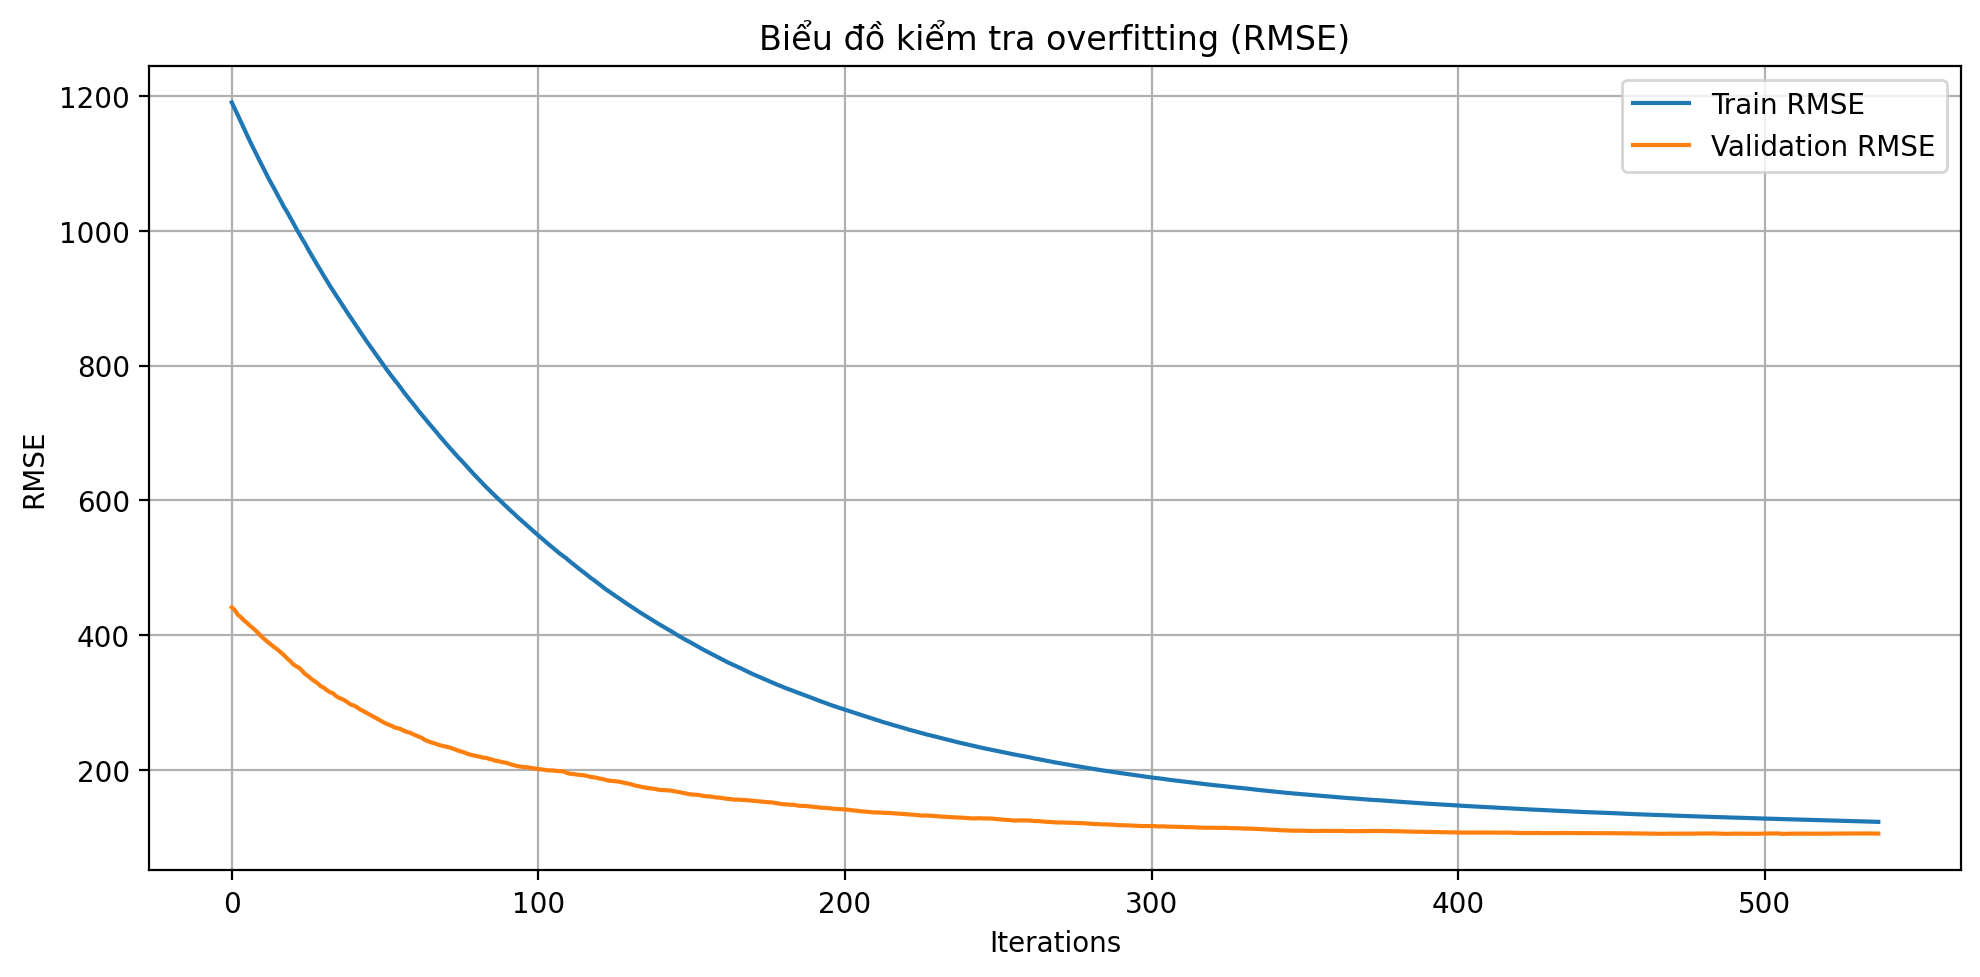

In [13]:
# Truy xuất kết quả huấn luyện
results = model.evals_result_

# Kiểm tra metric đang dùng
metric_name = list(results['learn'].keys())[0]

# Lấy loss của tập train và validation
train_loss = results['learn'][metric_name]
val_loss   = results['validation'][metric_name]

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train ' + metric_name.upper())
plt.plot(val_loss,   label='Validation ' + metric_name.upper())
plt.xlabel("Iterations")
plt.ylabel(metric_name.upper())
plt.title(f"Biểu đồ kiểm tra overfitting ({metric_name.upper()})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Biểu đồ dự đoán trên tập Test

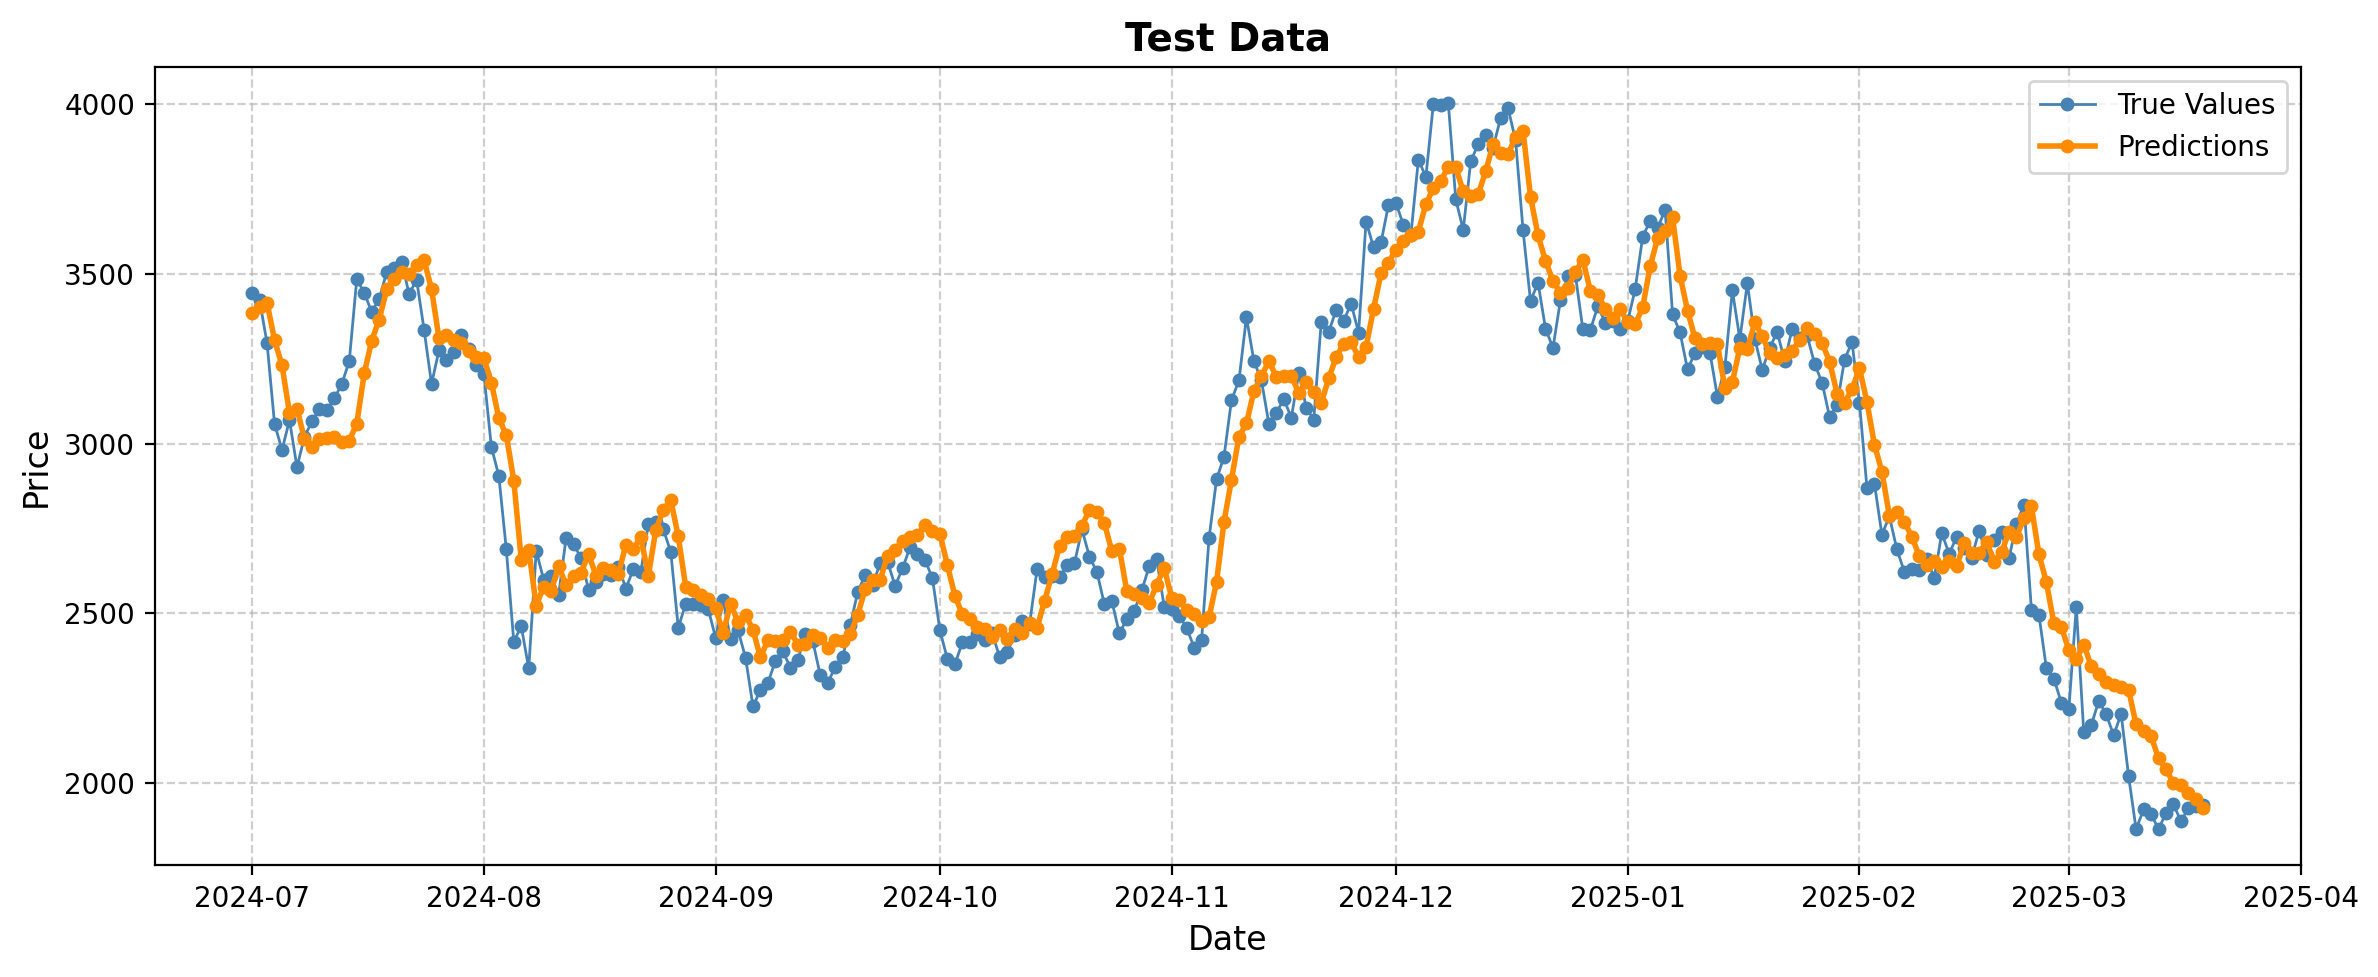

In [14]:
# Chuẩn bị dữ liệu
x = test_predict.index
y_true = df_test['Price'].loc[x].values
y_pred = test_predict.values

# Vẽ biểu đồ
plt.figure(figsize=(12, 5))

# Dữ liệu thật
plt.plot(x, y_true, label='True Values', color='steelblue', marker='o', markersize=4, linewidth=1)

# Dữ liệu dự đoán
plt.plot(x, y_pred, label='Predictions', color='darkorange', marker='o', markersize=4, linewidth=2)

# Vẽ biểu đồ
plt.title("Test Data", fontsize=14, weight='bold')
plt.xlabel("Date" if isinstance(x[0], pd.Timestamp) else "Time Step", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

#Triển khai phương pháp dự báo giá Ethereum tương lai (30, 60, 90 ngày)

In [15]:
# Hàm dự đoán tương lai
def forecast_future(model, df_recent, days=30, window_size=100):
    feature_cols = [col for col in df_recent.columns if col != 'Price']
    history = df_recent[feature_cols + ['Price']].values[-window_size:].tolist()
    preds = []

    for _ in range(days):
        x_input = np.array(history[-window_size:])[:, :-1].flatten().reshape(1, -1)
        yhat = model.predict(x_input)[0]
        new_row = history[-1][:-1] + [yhat]
        history.append(new_row)
        preds.append(yhat)

    start_date = pd.to_datetime(df_recent.index[-1]) + pd.Timedelta(days=1)
    future_dates = pd.date_range(start=start_date, periods=days, freq='D')
    return pd.Series(preds, index=future_dates)

# Dự đoán tương lai cho 30, 60 và 90 ngày
future_30 = forecast_future(model, df_test, days=30)
future_60 = forecast_future(model, df_test, days=60)
future_90 = forecast_future(model, df_test, days=90)

#Trực quan hóa chuỗi thời gian: Dự đoán và Dự báo giá Ethereum

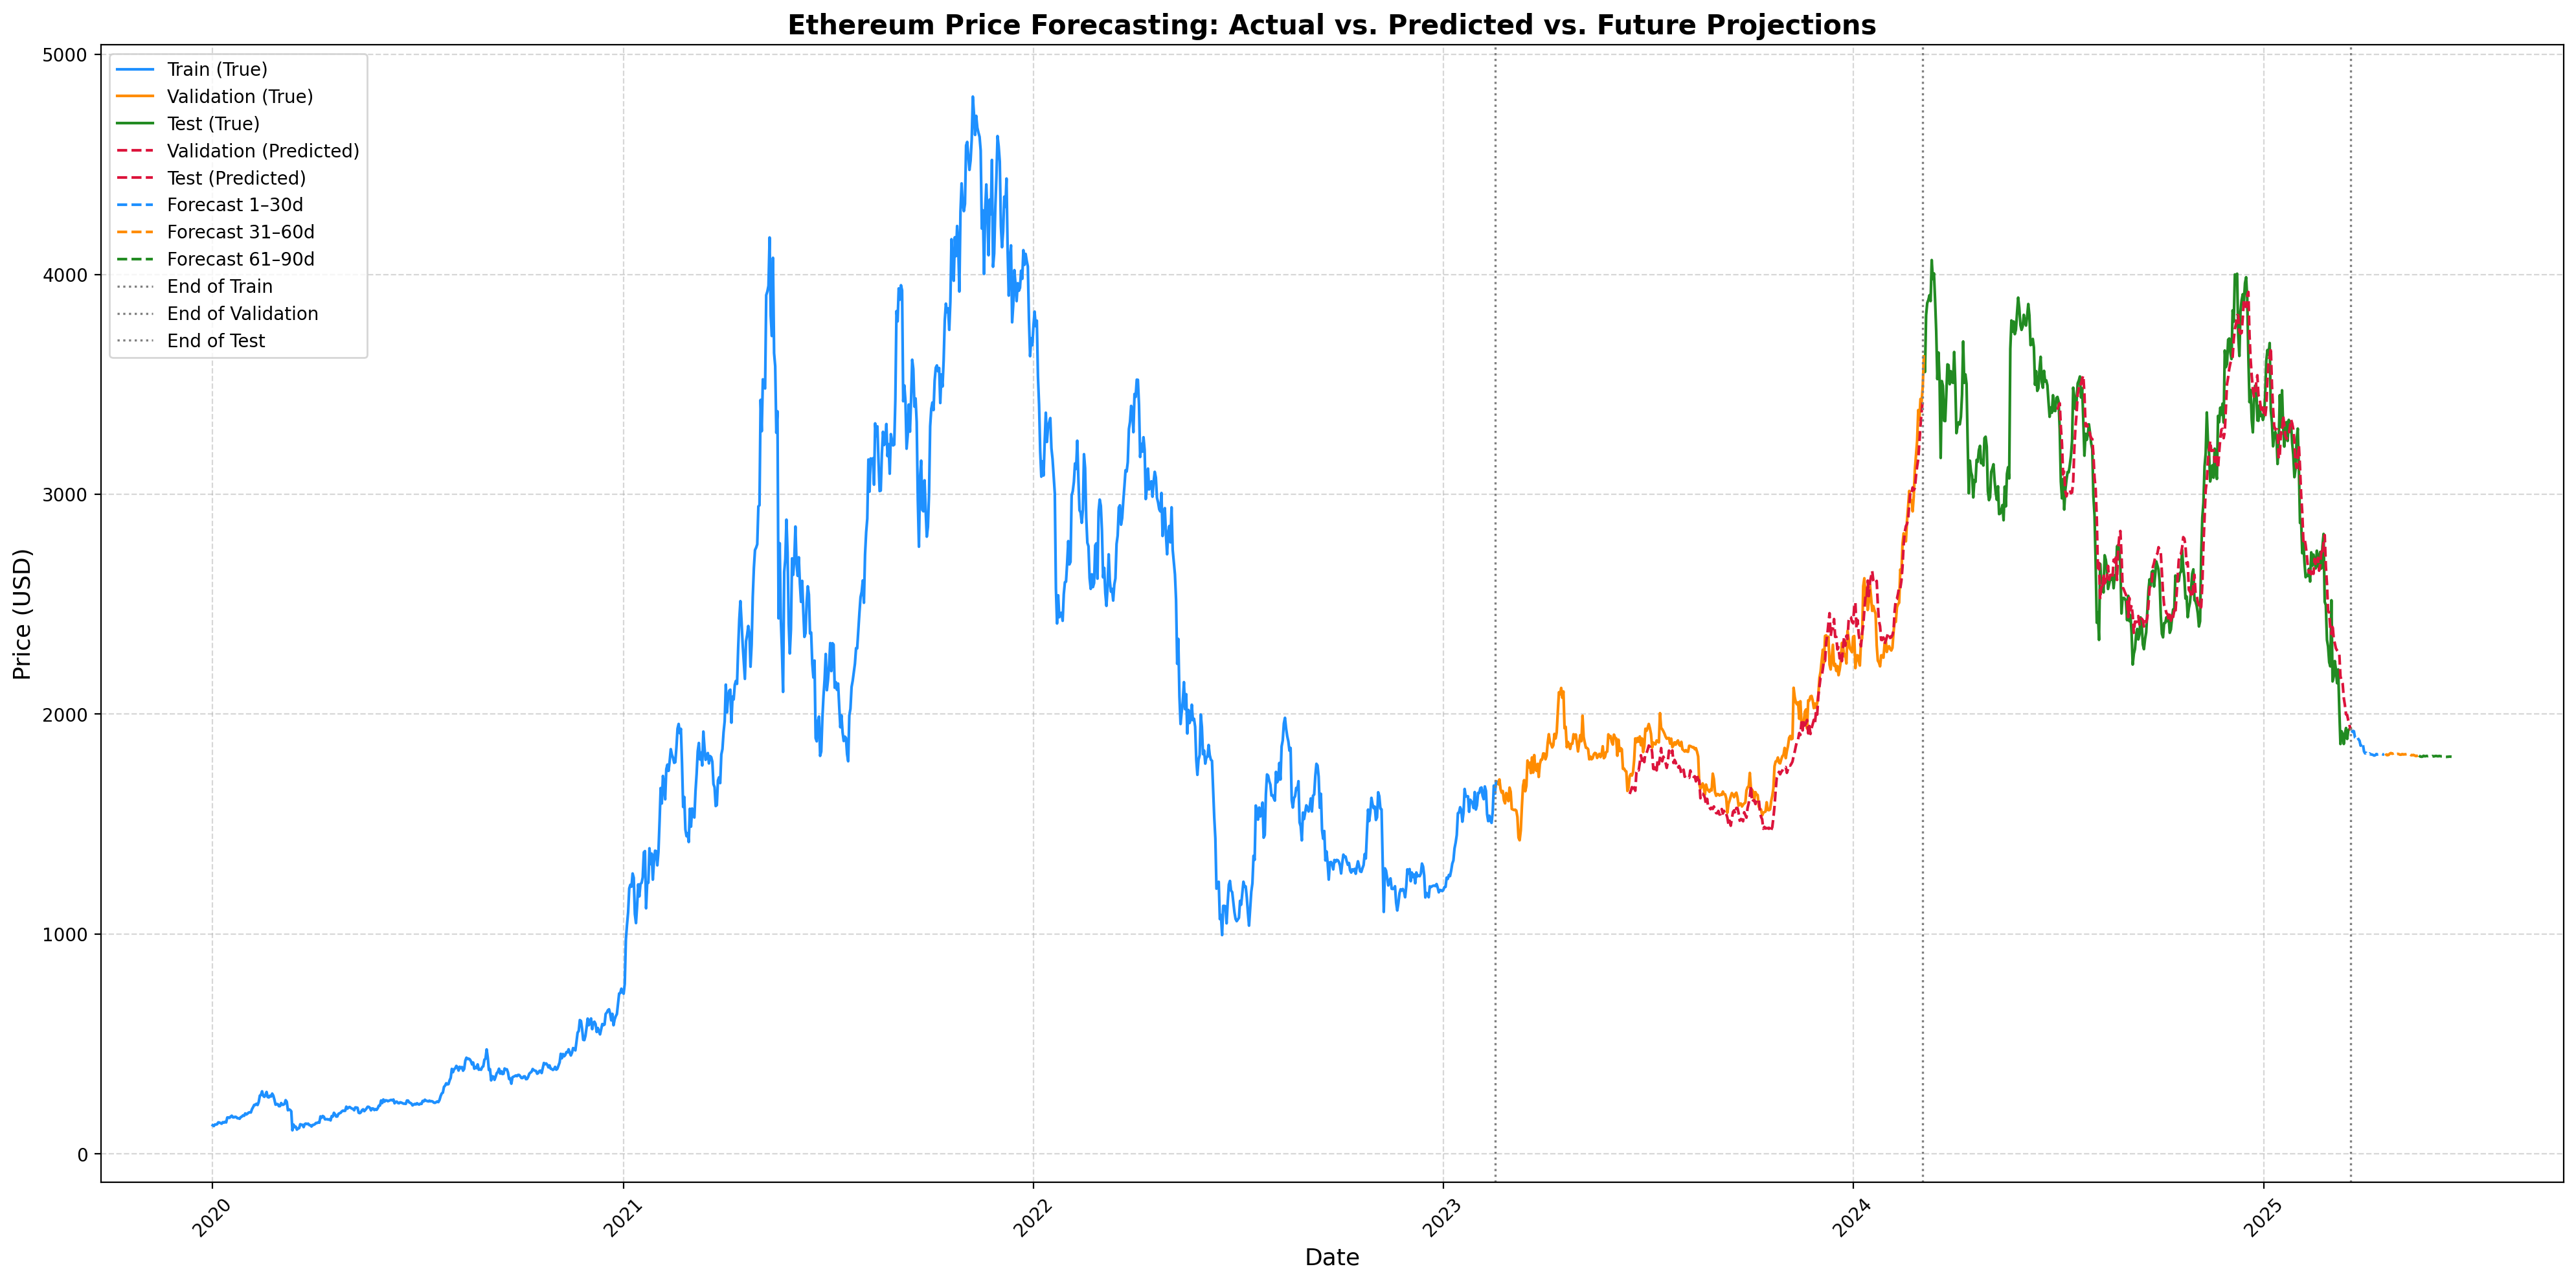

In [16]:
plt.figure(figsize=(20, 10))

# True (Train, Val, Test)
plt.plot(df_train_plot.index, df_train_plot['Price'], label='Train (True)', color='dodgerblue')
plt.plot(df_val_plot.index, df_val_plot['Price'], label='Validation (True)', color='darkorange')
plt.plot(df_test_plot.index, df_test_plot['Price'], label='Test (True)', color='forestgreen')

# Khoảng cách 1 ngày
plt.plot(
    [df_train_plot.index[-1], df_val_plot.index[0]],
    [df_train_plot['Price'].iloc[-1], df_val_plot['Price'].iloc[0]],
    color='dodgerblue')

plt.plot(
    [df_val_plot.index[-1], df_test_plot.index[0]],
    [df_val_plot['Price'].iloc[-1], df_test_plot['Price'].iloc[0]],
    color='darkorange')

# Val predicted và Test Predicted
plt.plot(val_predict.index, val_predict.values, label='Validation (Predicted)',
         color='crimson', linestyle='--')
plt.plot(test_predict.index, test_predict.values, label='Test (Predicted)',
         color='crimson', linestyle='--')

# Dự đoán 30, 60, 90 ngày tiếp theo
plt.plot(future_30.index, future_30, label='Forecast 1–30d', color='dodgerblue', linestyle='--')
plt.plot(future_60.index[30:], future_60[30:], label='Forecast 31–60d', color='darkorange', linestyle='--')
plt.plot(future_90.index[60:], future_90[60:], label='Forecast 61–90d', color='forestgreen', linestyle='--')

# Đường ngăn cách giai đoạn
plt.axvline(x=df_train.index[-1], color='gray', linestyle=':', linewidth=1.2, label='End of Train')
plt.axvline(x=df_val.index[-1], color='gray', linestyle=':', linewidth=1.2, label='End of Validation')
plt.axvline(x=df_test.index[-1], color='gray', linestyle=':', linewidth=1.2, label='End of Test')

plt.xlabel("Date", fontsize=13)
plt.ylabel("Price (USD)", fontsize=13)
plt.title("Ethereum Price Forecasting: Actual vs. Predicted vs. Future Projections", fontsize=15, weight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()